# ETL Pipeline: Transform

## Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd

from src.transform.topic_modelling import TopicModellor
from src.transform.message_classification import classify_messages
from src.transform.email_summary import summarize_messages
from src.transform.ner import extract_ner
from src.transform.spam_classification import classify_spam_messages
from src.database.chroma_manager import ChromaManager

logging.basicConfig(level=logging.INFO)

/home/belalm-linux/miniconda3/envs/qib/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Transformations

### Retrieve from Checkpoint

In [2]:
message_df = pd.read_csv("./data/interim/preprocessed_messages.csv")

### Retrieve Quarterly, Monthly, and Weekly Sets of Messages from DB

### Filter Emails

Most feature engineering tasks don't need to be run on all emails. The following feature engineering tasks are intended for customer oriented emails. We can safely disregard internal emails and outgoing emails.

In [3]:
customer_df = message_df.loc[(message_df["is_internal"] == False) & (message_df["from_address"] != "info@qib.com.qa")]

#### Spam Classification

Further filter by removing spam emails.

In [ ]:
customer_df = classify_spam_messages(customer_df)
customer_df = customer_df.loc[customer_df["is_spam"] == False]

### Vectorization of Emails

Setup Sentence Transformer and ChromaDB

In [4]:
chroma = ChromaManager("message_embeddings")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: src/models/all-MiniLM-L6-v2


Get or Create Sentence Embeddings

In [5]:
customer_df = chroma.populate_embeddings(customer_df)

Found 5039 embeddings in the database
Adding 0 new documents to the database
Added 0 documents to the database


### Feature Engineering and Modelling

#### Intent Analysis 

In [6]:
topic_modellor = TopicModellor(customer_df)
customer_df = topic_modellor.cluster_topics()

In [13]:
unigram_frequencies, bigram_frequencies, trigram_frequencies = topic_modellor.get_n_gram_frequencies()

Top 10 Clusters and Their Sizes

In [8]:
bigram_frequencies.loc[bigram_frequencies['topic_id'] != -1]['topic_id'].value_counts().head(10)

topic_id
48    33905
25    12265
75     8267
12     7843
30     6619
32     5839
2      5835
26     5723
69     4949
53     4533
Name: count, dtype: int64

Get the Descriptions for Each Topic

In [11]:
cluster_descriptions = topic_modellor.get_topic_descriptions()
cluster_descriptions.head(10)

ValueError: Ollama call failed with status code 500. Details: {"error":"model requires more system memory (2.3 GiB) than is available (804.4 MiB)"}

Showcase Word Cloud per Cluster

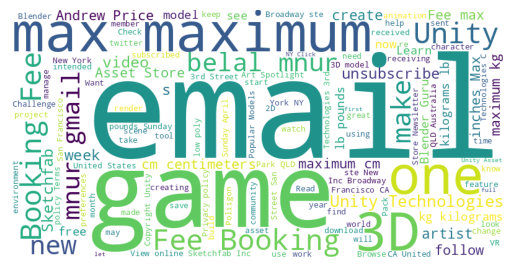

In [15]:
plt.axis("off")
plt.imshow(topic_modellor.generate_word_cloud(48))

Export to CSV

In [ ]:
customer_df.to_csv("./data/processed/customer_messages.csv", index=False)

#### Message Classification

In [ ]:
customer_df = classify_messages(customer_df)

#### Named Entity Recognition

In [ ]:
customer_df = extract_ner(customer_df)

#### Email Summarization

In [ ]:
customer_df = summarize_messages(customer_df)